In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
inspect(engine).get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Finding column names of both tables
measurement_cols = [(i["name"], i["type"]) for i in inspect(engine).get_columns("Measurement")]
station_cols = [(i["name"], i["type"]) for i in inspect(engine).get_columns("Station")]
# measurement_cols
station_cols

[('id', INTEGER()),
 ('station', TEXT()),
 ('name', TEXT()),
 ('latitude', FLOAT()),
 ('longitude', FLOAT()),
 ('elevation', FLOAT())]

# Exploratory Climate Analysis

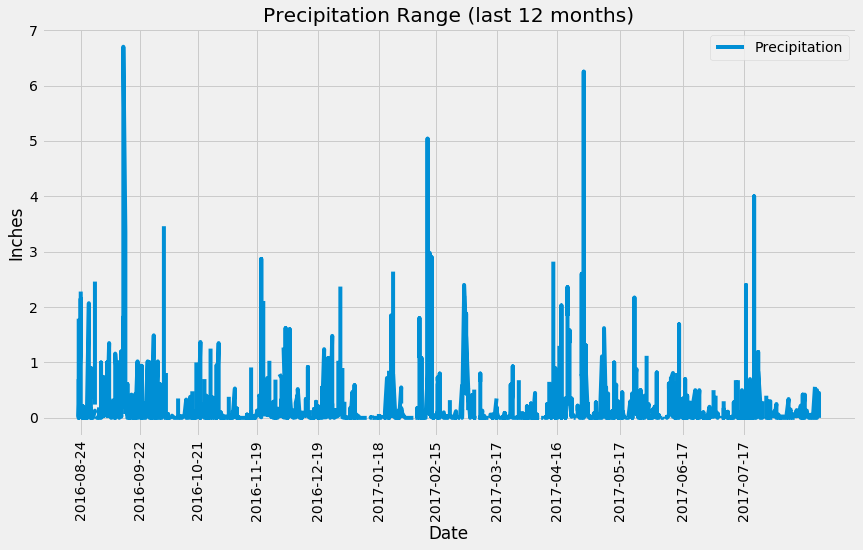

In [11]:
# Finding the max date value in the table
max_date = session.query(func.max(Measurement.date)).first()[0].split("-")

# Creating a max_date datetime object
max_date_obj = dt.date(int(max_date[0]),int(max_date[1]),int(max_date[2]))

# Calculating the date 1 year ago from the last data point in the database
start_date = max_date_obj - dt.timedelta(days=365)

# Querying date and precipitation data
prcp = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date>=start_date) \
    .order_by(Measurement.date.desc()).all()

# Saving the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns=["Date","Prcp"]).sort_values("Date", ascending=True)

# Calculating x-tick values
num_of_ticks = len(prcp_df.Date)//12
count = []
index = 0
for i in range(12):
    index = index + num_of_ticks
    count.append(index) 
ticks = [prcp_df["Date"][i] for i in count]

# Plotting the last 12 months of precipitation
plt.figure(figsize=(13,7))
plt.plot(prcp_df["Date"],prcp_df["Prcp"],label="Precipitation")
plt.title("Precipitation Range (last 12 months)")
plt.ylabel("Inches")
plt.xlabel(f"Date")
plt.legend()
plt.xticks(ticks,rotation=90)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = session.query(Station.id).count()
print(f"Number of stations: {num_of_stations}")

Number of stations: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.id, Station.station, func.count(Measurement.station)) \
    .filter(Station.station==Measurement.station) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()).all()

[(7, 'USC00519281', 2772),
 (1, 'USC00519397', 2724),
 (2, 'USC00513117', 2709),
 (6, 'USC00519523', 2669),
 (9, 'USC00516128', 2612),
 (3, 'USC00514830', 2202),
 (8, 'USC00511918', 1979),
 (4, 'USC00517948', 1372),
 (5, 'USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temp = session.query(func.min(Measurement.tobs)) \
    .filter(Measurement.station==Station.station) \
    .filter(Station.id==7).all()
max_temp = session.query(func.max(Measurement.tobs)) \
    .filter(Measurement.station==Station.station) \
    .filter(Station.id==7).all()
avg_temp = session.query(func.avg(Measurement.tobs)) \
    .filter(Measurement.station==Station.station) \
    .filter(Station.id==7).all()

print(f"""Min Temperature: {min_temp[0][0]}
Max Temperature: {max_temp[0][0]}
Average Temperature: {round(avg_temp[0][0],2)}""")

Min Temperature: 54.0
Max Temperature: 85.0
Average Temperature: 71.66


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observation_station = session.query(Station.id, Measurement.station, func.count(Measurement.tobs)) \
    .filter(Measurement.station==Station.station) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.tobs).desc()).first()
print(f"Station with highest number of temperature observations: {observation_station}")

Station with highest number of temperature observations: (7, 'USC00519281', 2772)


In [17]:
# Finding temerature data for highest observation station
obsv_station_temp = session.query(Measurement.date, Measurement.tobs) \
    .filter(Measurement.date>=start_date) \
    .filter(Measurement.station==observation_station[1]) \
    .order_by(Measurement.date.desc()).all()
obsv_station_temp[:5]

[('2017-08-18', 79.0),
 ('2017-08-17', 76.0),
 ('2017-08-16', 76.0),
 ('2017-08-15', 77.0),
 ('2017-08-14', 77.0)]

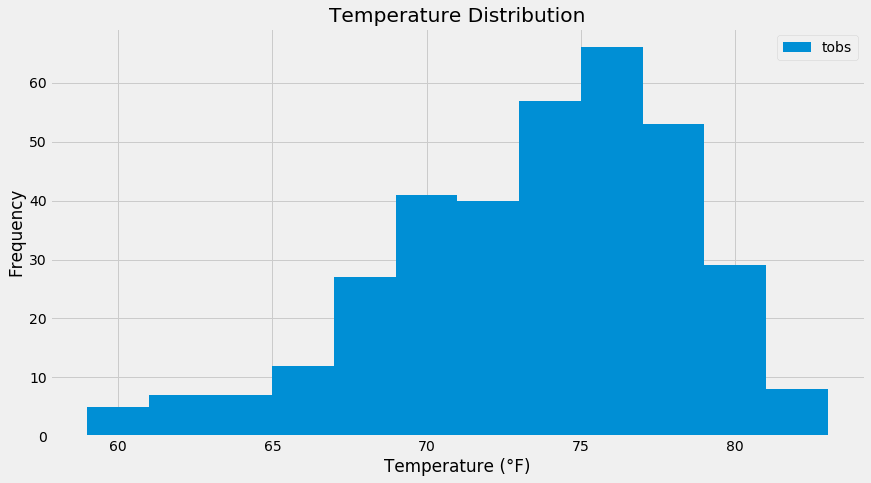

In [18]:
# Plotting
tobs_df = pd.DataFrame(obsv_station_temp, columns=["date","tobs"]).sort_values("date",ascending=True)
plt.figure(figsize=(13,7))
plt.ylabel(f"Frequency")
plt.xlabel("Temperature (°F)")
plt.title(f"Temperature Distribution")
plt.hist(tobs_df.tobs,bins=12,width=2,label="tobs")
plt.legend()
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
years=["2010", "2011","2012", "2013", "2014", "2015","2016"]
j_min_temps = []
j_avg_temps = []
j_max_temps = []
d_min_temps = []
d_avg_temps = []
d_max_temps = []
data_year = []

for year in years:
    j_temps = calc_temps(f"{year}-06-01", f"{year}-06-30")
    j_min_temps.append(j_temps[0][0])
    j_avg_temps.append(j_temps[0][1])
    j_max_temps.append(j_temps[0][2])
    
    d_temps = calc_temps(f"{year}-12-01", f"{year}-12-31")
    d_min_temps.append(d_temps[0][0])
    d_avg_temps.append(d_temps[0][1])
    d_max_temps.append(d_temps[0][2])
    
    data_year.append(year)

df = pd.DataFrame({
    "year":data_year,
    "j_avg_temps":j_avg_temps,
    "j_min_temps":j_min_temps,
    "j_max_temps":j_max_temps,
    "d_avg_temps":d_avg_temps,
    "d_min_temps":d_min_temps,
    "d_max_temps":d_max_temps
})
df

,year,j_avg_temps,j_min_temps,j_max_temps,d_avg_temps,d_min_temps,d_max_temps
0,2010,74.925620,67.0,85.0,70.208511,58.0,80.0
1,2011,73.938326,65.0,82.0,70.820628,63.0,77.0
2,2012,74.000000,68.0,81.0,71.188073,61.0,80.0
3,2013,74.599078,66.0,81.0,71.094017,63.0,83.0
4,2014,75.027907,67.0,84.0,69.896861,56.0,81.0
5,2015,74.990148,66.0,81.0,73.423913,65.0,82.0
6,2016,75.175258,64.0,81.0,71.130000,60.0,78.0


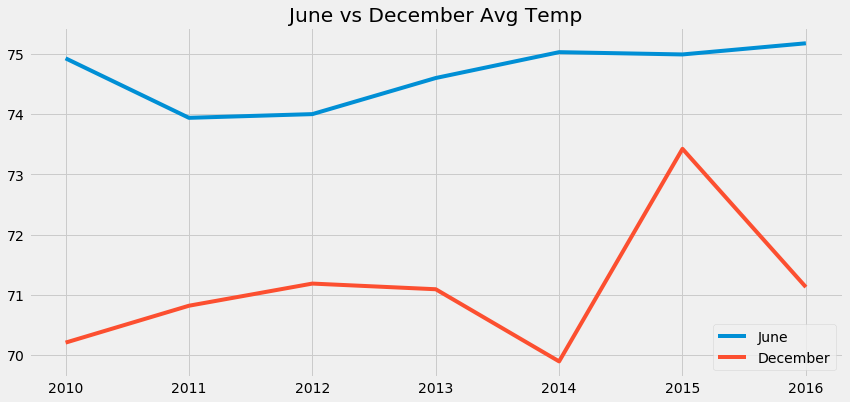

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(13,6))
plt.plot(df.year,df.j_avg_temps,label="June")
plt.plot(df.year,df.d_avg_temps,label="December")
plt.title("June vs December Avg Temp")
plt.legend()
plt.show()

In [22]:
from scipy import stats
stats.ttest_ind(j_avg_temps,d_avg_temps)

Ttest_indResult(statistic=7.570096659210406, pvalue=6.587882812736172e-06)

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
